In [1]:
import os
os.listdir('/content')

['.config', 'BTC-USDT_fewer_trades.parquet', 'sample_data']

In [3]:
import pandas as pd

df = pd.read_parquet('/content/BTC-USDT_fewer_trades.parquet')

df.head()

,ts,side,qty,trade_price,Exchange
index,,,,,
846,2025-05-22 00:00:00.059739309,B,0.000080,109646.0,OKX
958,2025-05-22 00:00:00.172964441,B,0.000181,109648.0,OKX
959,2025-05-22 00:00:00.176589875,B,0.000010,109650.0,OKX
960,2025-05-22 00:00:00.176589875,B,0.003134,109654.4,OKX
968,2025-05-22 00:00:00.179674740,B,0.000015,109655.3,OKX


In [5]:
df['ts'] = pd.to_datetime(df['ts'])
df = df.sort_values('ts')

train_test = {}

for ex, ex_df in df.groupby('Exchange'):
    n = len(ex_df)
    split = int(0.4 * n)

    train_test[ex] = {
        "train": ex_df.iloc[:split].copy(),
        "test":  ex_df.iloc[split:].copy()
    }

Time ordering, exchange split, and training/testing data split

In [9]:
import pandas as pd

df['ts'] = pd.to_datetime(df['ts'])
df = df.sort_values('ts')

train_test = {}

for ex, ex_df in df.groupby('Exchange'):
    n = len(ex_df)
    split = int(0.4 * n)

    train_test[ex] = {
        "train": ex_df.iloc[:split].copy(),
        "test":  ex_df.iloc[split:].copy()
    }

tau = pd.Timedelta(seconds=1)
exchange = "BINANCE"

train_df = train_test[exchange]['train'].copy()
test_df  = train_test[exchange]['test'].copy()

train_df['ts'] = pd.to_datetime(train_df['ts'])
test_df['ts']  = pd.to_datetime(test_df['ts'])

train_df = train_df.set_index('ts')
test_df  = test_df.set_index('ts')

train_df['signed_qty'] = train_df['qty'] * train_df['side'].map({'B': 1, 'A': -1})
test_df['signed_qty']  = test_df['qty']  * test_df['side'].map({'B': 1, 'A': -1})

In [10]:
train_df['F_tau'] = train_df['signed_qty'].rolling(tau, closed='left').sum()
test_df['F_tau']  = test_df['signed_qty'].rolling(tau, closed='left').sum()

In [13]:
T = pd.Timedelta(seconds=1)

train_df['price_fwd'] = train_df['trade_price'].shift(-1)

train_df['r_T'] = (
    train_df['price_fwd'] - train_df['trade_price']
) / train_df['trade_price']

train_df = train_df.dropna(subset=['F_tau', 'r_T'])

In [14]:
import numpy as np

X = train_df['F_tau'].values
y = train_df['r_T'].values

beta = np.dot(X, y) / np.dot(X, X)
beta

np.float64(3.79553866727108e-08)

In [15]:
print("beta:", beta)
print("sign(beta):", np.sign(beta))
print("mean F_tau:", X.mean())
print("mean r_T:", y.mean())

beta: 3.79553866727108e-08
sign(beta): 1.0
mean F_tau: 0.369247099203572
mean r_T: 1.1429516623317916e-08


Sanity number check

In [17]:
test_df['r_hat'] = beta * test_df['F_tau']

test_df = test_df.dropna(subset=['r_hat'])

j = test_df['r_hat'].abs().quantile(0.95)
j

np.float64(2.425482052239575e-07)

In [18]:
test_df['trade'] = (test_df['r_hat'].abs() > j)

test_df['direction'] = np.sign(test_df['r_hat'])

In [19]:
test_df['trade'].mean()

np.float64(0.04996694443644304)

In [21]:
test_df['price_exit'] = test_df['trade_price'].shift(-1)
test_df['trade_qty'] = test_df['qty']
test_df['pnl'] = (
    test_df['trade'] *
    test_df['direction'] *
    (test_df['price_exit'] - test_df['trade_price']) *
    test_df['trade_qty']
)
test_df = test_df.dropna(subset=['pnl'])

In [22]:
total_pnl = test_df['pnl'].sum()
mean_pnl  = test_df.loc[test_df['trade'], 'pnl'].mean()
print("Total P&L:", total_pnl)
print("Mean P&L per trade:", mean_pnl)
print("Number of trades:", test_df['trade'].sum())

Total P&L: -38.921186199845764
Mean P&L per trade: -0.0005472530785540946
Number of trades: 71121


In [23]:
trade_pnl = test_df.loc[test_df['trade'], 'pnl']

sharpe = trade_pnl.mean() / trade_pnl.std()
sharpe

np.float64(-0.0015082033310784228)

In [24]:
trade_pnl.describe(percentiles=[0.01, 0.05, 0.95, 0.99])

,pnl
count,71121.000000
mean,-0.000547
std,0.362851
min,-28.583718
1%,-0.088386
5%,-0.001045
50%,0.000000
95%,0.000810
99%,0.070298
max,50.631084


This is a good start. We want the mean of trades to be near 0 for such high frequency strategies. Our tails are pretty fat too, so this will make for quality analysis and optimization. Let's look closer at this.

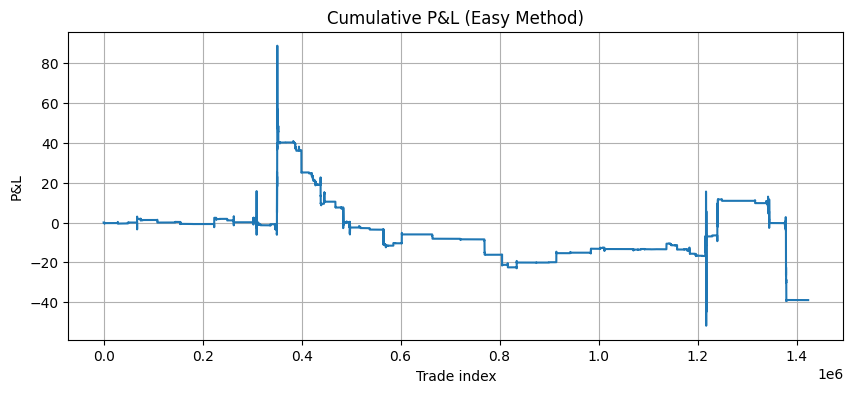

In [25]:
test_df['cum_pnl'] = test_df['pnl'].cumsum()
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(test_df['cum_pnl'].values)
plt.title('Cumulative P&L (Easy Method)')
plt.xlabel('Trade index')
plt.ylabel('P&L')
plt.grid(True)
plt.show()

In [26]:
cum = test_df['cum_pnl']
peak = cum.cummax()
drawdown = cum - peak

drawdown.min()

-140.48705959995476

Before optimizing, run more analysis and include trading costs.

Net P&L stats (with costs):
count    1.423360e+06
mean    -1.443152e-01
std      1.090352e+00
min     -2.283348e+02
1%      -3.239989e+00
5%      -3.999887e-01
50%     -1.114960e-03
95%     -1.104908e-03
99%     -1.103280e-03
max      3.517946e+01
Name: pnl_net, dtype: float64


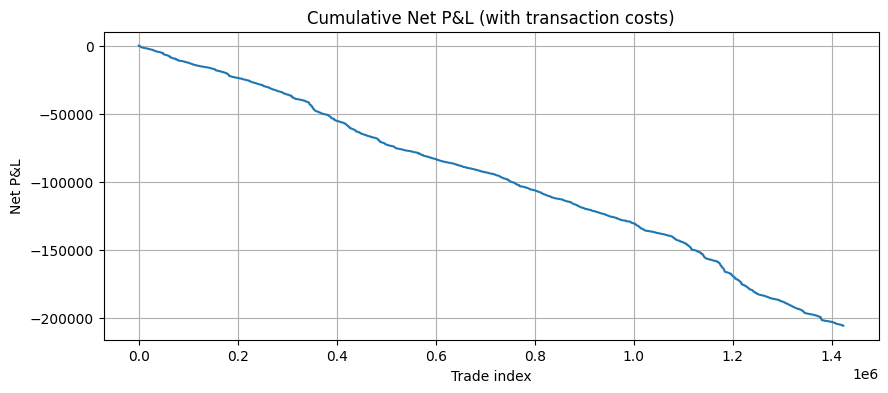

Maximum drawdown: -205411.51666693387


In [27]:
import numpy as np
import matplotlib.pyplot as plt

#Define cost parameters

cost_rate = 0.0002

#Compute trade notional

test_df['notional'] = test_df['trade_price'] * test_df['qty']

#Compute cost per trade
test_df['cost'] = cost_rate * test_df['notional']

#Net P&L

test_df['pnl_net'] = test_df['pnl'] - test_df['cost']

#Summary statistics
print("Net P&L stats (with costs):")
print(test_df['pnl_net'].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

#Cumulative net P&L
test_df['cum_pnl_net'] = test_df['pnl_net'].cumsum()

plt.figure(figsize=(10,4))
plt.plot(test_df['cum_pnl_net'].values)
plt.title('Cumulative Net P&L (with transaction costs)')
plt.xlabel('Trade index')
plt.ylabel('Net P&L')
plt.grid(True)
plt.show()

#Drawdowns
cum = test_df['cum_pnl_net']
drawdown = cum - cum.cummax()
print("Maximum drawdown:", drawdown.min())

New threshold j: 5.000713287057662e-07


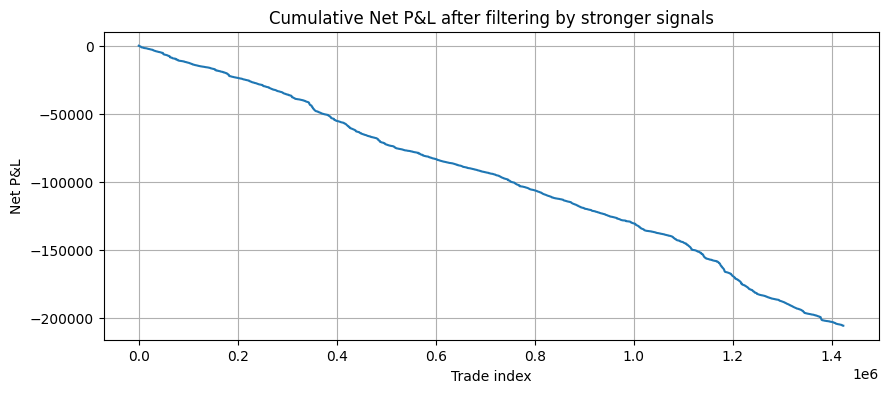

Filtered P&L summary:
count    1.423360e+06
mean    -1.443007e-01
std      1.089618e+00
min     -2.283348e+02
1%      -3.239477e+00
5%      -3.999880e-01
50%     -1.114947e-03
95%     -1.104993e-03
99%     -1.103700e-03
max      3.517946e+01
Name: pnl_filtered, dtype: float64


In [28]:
abs_rhat = test_df['r_hat'].abs()

j_new = abs_rhat.quantile(0.98)
print("New threshold j:", j_new)

test_df['trade_filtered'] = abs_rhat > j_new
test_df['direction_filtered'] = np.sign(test_df['r_hat'])

test_df['pnl_filtered'] = (
    test_df['trade_filtered'] *
    test_df['direction_filtered'] *
    (test_df['price_exit'] - test_df['trade_price']) *
    test_df['trade_qty'] -
    test_df['cost']
)

test_df['cum_pnl_filtered'] = test_df['pnl_filtered'].cumsum()

plt.figure(figsize=(10,4))
plt.plot(test_df['cum_pnl_filtered'].values)
plt.title('Cumulative Net P&L after filtering by stronger signals')
plt.xlabel('Trade index')
plt.ylabel('Net P&L')
plt.grid(True)
plt.show()

print("Filtered P&L summary:")
print(test_df['pnl_filtered'].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))

Still really bad after more filtering. Made next block to quicken the process and add greater customizability to the strategy. Also will allow it to loop over all exchanges.


=== Processing BINANCE ===
Estimated beta: 0.000000
Filtered net P&L summary:
count    1.423360e+06
mean    -7.217125e-02
std      5.502682e-01
min     -1.141674e+02
1%      -1.617606e+00
5%      -1.999917e-01
50%     -5.574800e-04
95%     -5.524456e-04
99%     -5.515200e-04
max      4.290527e+01
Name: pnl_net, dtype: float64
Maximum drawdown: -102725.21892656668


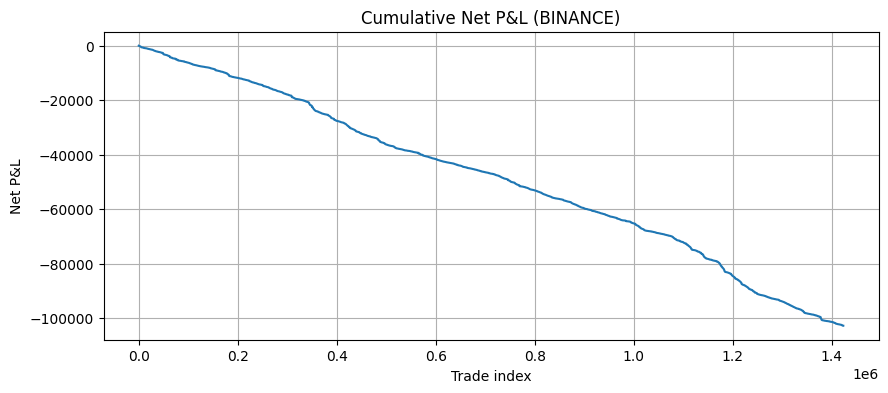


=== Processing BITSTAMP ===
Estimated beta: -0.000270
Filtered net P&L summary:
count    1418.000000
mean       -0.541415
std        14.625236
min      -506.540923
1%         -7.361070
5%         -1.098167
50%        -0.025955
95%        -0.001078
99%        -0.000015
max       202.994222
Name: pnl_net, dtype: float64
Maximum drawdown: -767.705222537041


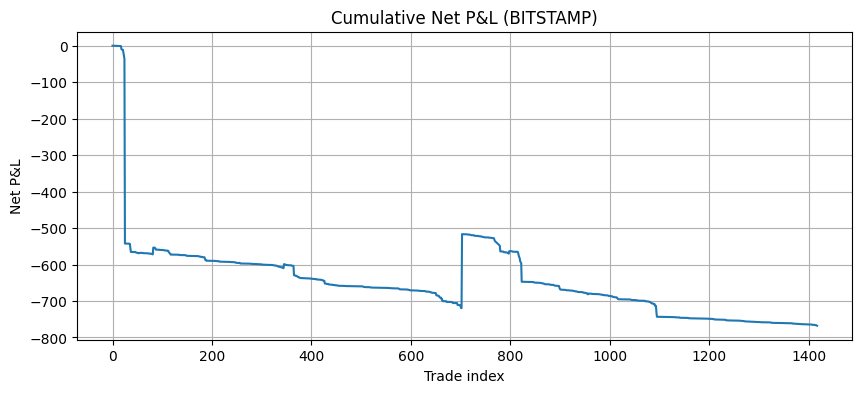


=== Processing COINBASE ===
Estimated beta: 0.000017
Filtered net P&L summary:
count    182650.000000
mean         -0.121567
std           0.279509
min         -52.867897
1%           -0.676555
5%           -0.324928
50%          -0.075060
95%          -0.001815
99%          -0.000012
max          34.973923
Name: pnl_net, dtype: float64
Maximum drawdown: -22204.057222994572


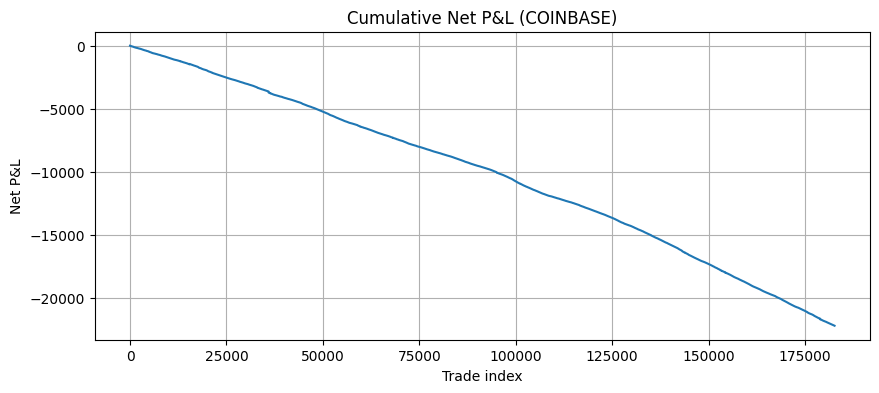


=== Processing DERIBIT ===
Estimated beta: -0.000000
Filtered net P&L summary:
count    1.878200e+04
mean    -1.410352e+02
std      6.839267e+04
min     -8.440067e+05
1%      -2.038538e+04
5%      -4.071240e+03
50%     -4.357640e+01
95%     -1.068396e+01
99%     -1.038140e+01
max      6.810358e+06
Name: pnl_net, dtype: float64
Maximum drawdown: -13449127.997199941


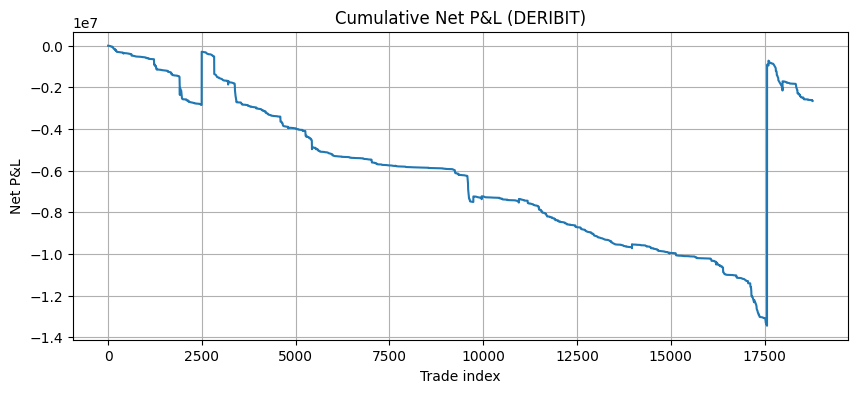


=== Processing GATE_IO ===
Estimated beta: 0.000002
Filtered net P&L summary:
count    2.693821e+06
mean    -1.903957e-01
std      3.320093e+00
min     -3.002157e+02
1%      -1.496899e+00
5%      -4.237935e-01
50%     -9.673479e-03
95%     -3.091623e-04
99%     -1.089716e-04
max      1.541042e+02
Name: pnl_net, dtype: float64
Maximum drawdown: -512891.8830321468


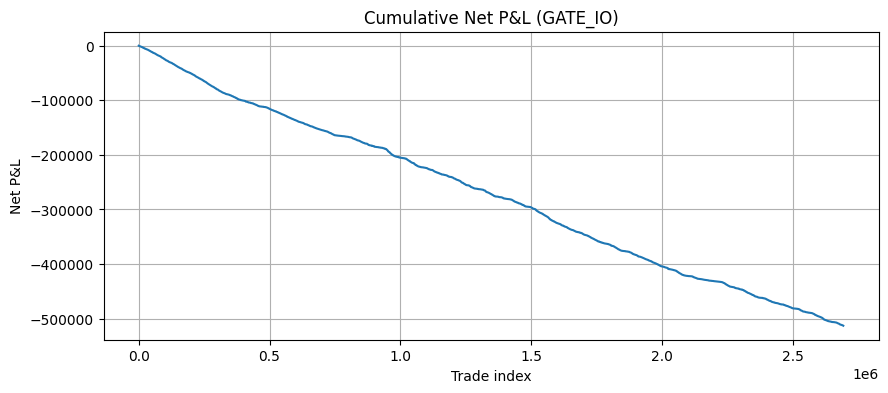


=== Processing OKX ===
Estimated beta: 0.000000
Filtered net P&L summary:
count    7.463646e+06
mean    -1.758964e-01
std      1.320375e+00
min     -1.710122e+03
1%      -2.861759e+00
5%      -7.008459e-01
50%     -6.193763e-03
95%     -1.044927e-04
99%     -1.024127e-04
max      8.704601e+01
Name: pnl_net, dtype: float64
Maximum drawdown: -1312828.2338480626


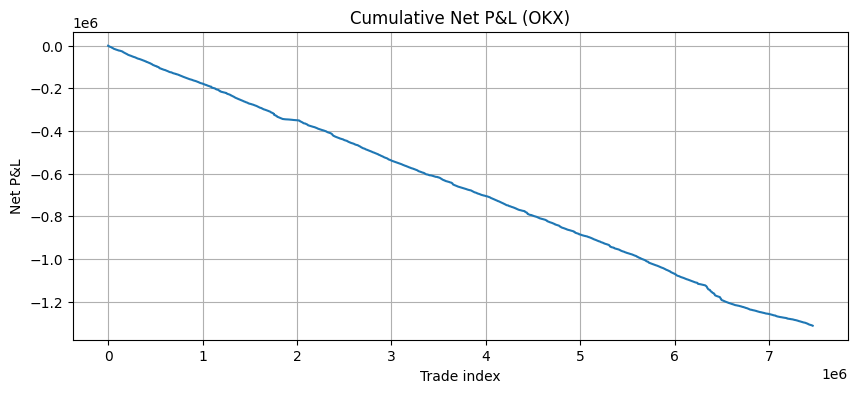


=== All exchanges processed ===


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tau = pd.Timedelta(seconds=1)
T = pd.Timedelta(seconds=1)
cost_rate = 0.0001
threshold_quantile = 0.95

results = {}

for exchange, dfs in train_test.items():
    print(f"\n=== Processing {exchange} ===")

    train_df = dfs['train'].copy()
    test_df = dfs['test'].copy()

    for df_ in [train_df, test_df]:
        df_['ts'] = pd.to_datetime(df_['ts'])
        df_ = df_.set_index('ts')

    train_df = train_df.set_index('ts')
    test_df = test_df.set_index('ts')

    train_df['signed_qty'] = train_df['qty'] * train_df['side'].map({'B':1, 'A':-1})
    test_df['signed_qty']  = test_df['qty']  * test_df['side'].map({'B':1, 'A':-1})

    train_df['F_tau'] = train_df['signed_qty'].rolling(tau, closed='left').sum()
    test_df['F_tau']  = test_df['signed_qty'].rolling(tau, closed='left').sum()

    train_df['price_fwd'] = train_df['trade_price'].shift(-1)
    train_df['r_T'] = (train_df['price_fwd'] - train_df['trade_price']) / train_df['trade_price']
    train_df = train_df.dropna(subset=['F_tau','r_T'])

    X = train_df['F_tau'].values
    y = train_df['r_T'].values
    beta = np.dot(X, y) / np.dot(X, X)
    print(f"Estimated beta: {beta:.6f}")

    test_df['r_hat'] = beta * test_df['F_tau']
    test_df = test_df.dropna(subset=['r_hat'])

    test_df['price_exit'] = test_df['trade_price'].shift(-1)
    test_df['trade_qty'] = test_df['qty']

    j = test_df['r_hat'].abs().quantile(threshold_quantile)
    test_df['trade_filtered'] = test_df['r_hat'].abs() > j
    test_df['direction_filtered'] = np.sign(test_df['r_hat'])

    test_df['pnl'] = (
        test_df['trade_filtered'] *
        test_df['direction_filtered'] *
        (test_df['price_exit'] - test_df['trade_price']) *
        test_df['trade_qty']
    )

    test_df['notional'] = test_df['trade_price'] * test_df['trade_qty']
    test_df['cost'] = cost_rate * test_df['notional']
    test_df['pnl_net'] = test_df['pnl'] - test_df['cost']

    test_df['cum_pnl_net'] = test_df['pnl_net'].cumsum()
    cum = test_df['cum_pnl_net']
    drawdown = cum - cum.cummax()

    summary = test_df['pnl_net'].describe(percentiles=[0.01,0.05,0.5,0.95,0.99])
    print("Filtered net P&L summary:")
    print(summary)
    print("Maximum drawdown:", drawdown.min())

    plt.figure(figsize=(10,4))
    plt.plot(test_df['cum_pnl_net'].values)
    plt.title(f'Cumulative Net P&L ({exchange})')
    plt.xlabel('Trade index')
    plt.ylabel('Net P&L')
    plt.grid(True)
    plt.show()

    results[exchange] = {
        'test_df': test_df,
        'beta': beta,
        'summary': summary,
        'max_drawdown': drawdown.min()
    }

print("\n=== All exchanges processed ===")

Let's further optimize to try and become profitable. Seperating noise from signal is key here. These two blocks are the testers to show code output and work on code. As such, second won't have trade costs to demonstrate per assignment.


=== Processing BINANCE ===
Estimated beta: 0.000000
Filtered net P&L summary:
count    1.424365e+06
mean    -1.069014e-04
std      9.181217e-02
min     -3.384771e+01
1%      -1.000000e-06
5%       0.000000e+00
50%      0.000000e+00
95%     -0.000000e+00
99%      3.000000e-06
max      5.063108e+01
Name: pnl_net, dtype: float64
Maximum drawdown: -167.16289189980895


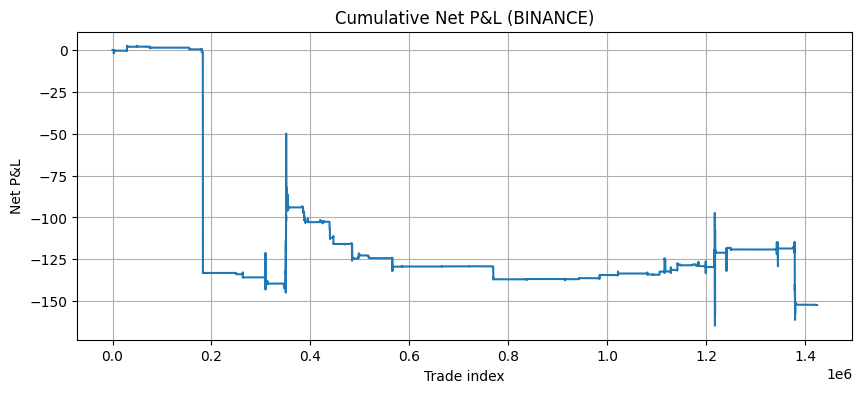


=== Processing BITSTAMP ===
Estimated beta: -0.000257
Filtered net P&L summary:
count    1535.000000
mean       -0.209897
std        13.885352
min      -498.823349
1%         -0.009504
5%          0.000000
50%         0.000000
95%         0.000000
99%        -0.000000
max       205.970496
Name: pnl_net, dtype: float64
Maximum drawdown: -507.32092224


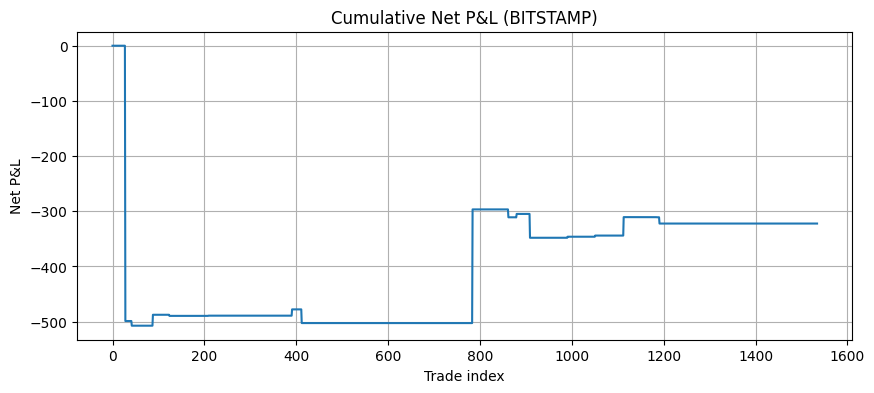


=== Processing COINBASE ===
Estimated beta: 0.000008
Filtered net P&L summary:
count    203963.000000
mean          0.000416
std           0.199259
min         -47.881939
1%           -0.002650
5%            0.000000
50%           0.000000
95%           0.000000
99%           0.016833
max          29.919239
Name: pnl_net, dtype: float64
Maximum drawdown: -109.96728102830639


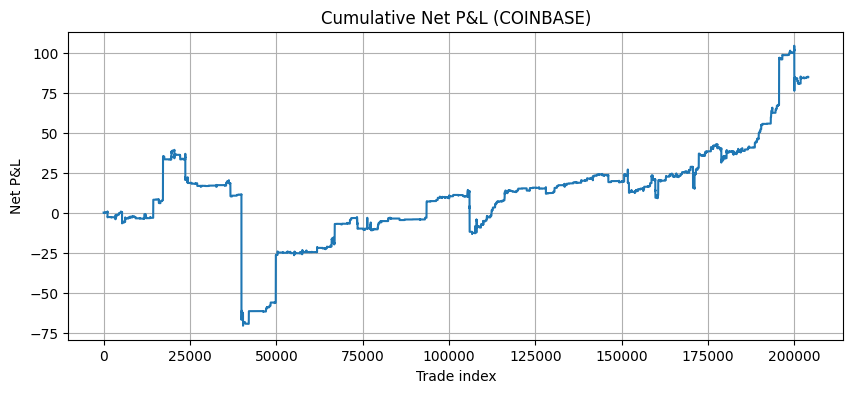


=== Processing DERIBIT ===
Estimated beta: -0.000000
Filtered net P&L summary:
count    2.193900e+04
mean     6.431932e+02
std      6.343898e+04
min     -8.248790e+05
1%       0.000000e+00
5%       0.000000e+00
50%      0.000000e+00
95%      0.000000e+00
99%      0.000000e+00
max      6.841290e+06
Name: pnl_net, dtype: float64
Maximum drawdown: -1929701.0


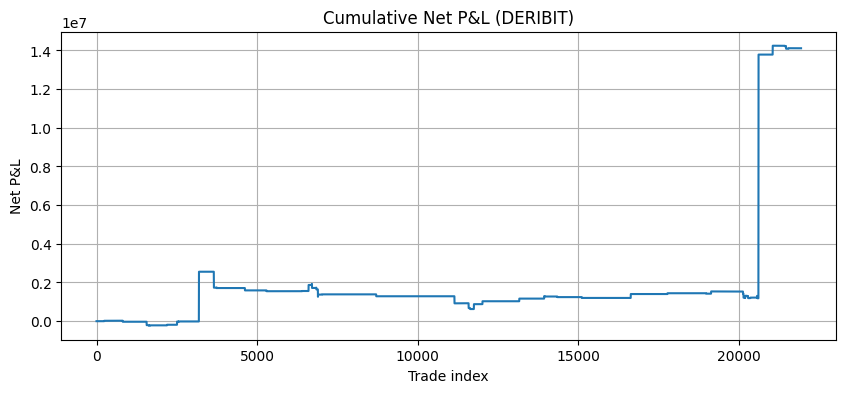


=== Processing GATE_IO ===
Estimated beta: 0.000001
Filtered net P&L summary:
count    2.850769e+06
mean     6.723035e-04
std      3.926340e-01
min     -2.491045e+02
1%       0.000000e+00
5%       0.000000e+00
50%      0.000000e+00
95%      0.000000e+00
99%      4.680000e-04
max      2.248890e+02
Name: pnl_net, dtype: float64
Maximum drawdown: -492.9818960000562


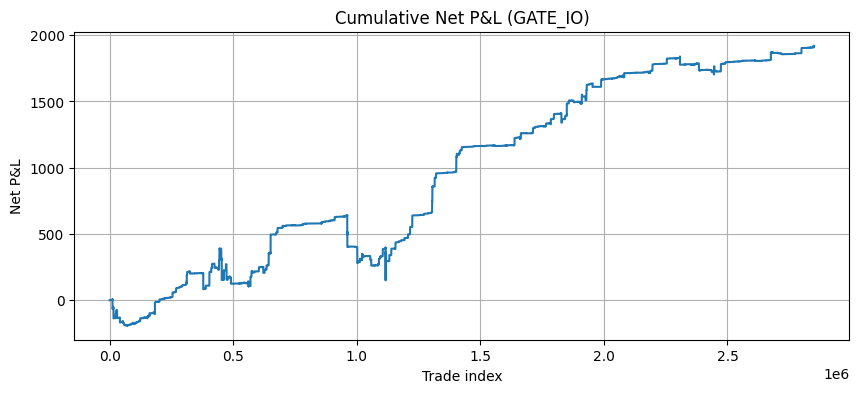


=== Processing OKX ===
Estimated beta: 0.000000
Filtered net P&L summary:
count    7.959666e+06
mean    -3.344707e-04
std      5.914736e-01
min     -1.502135e+03
1%      -7.026205e-05
5%       0.000000e+00
50%      0.000000e+00
95%     -0.000000e+00
99%      1.289922e-04
max      9.696582e+01
Name: pnl_net, dtype: float64
Maximum drawdown: -3387.396702280987


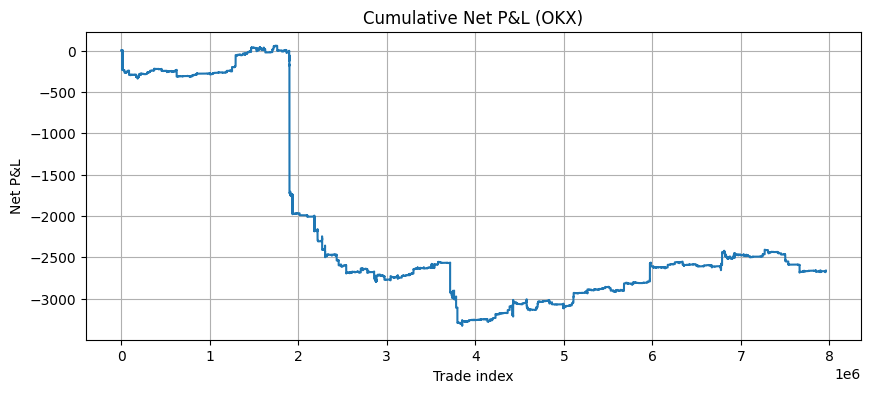


=== All exchanges processed ===


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tau = pd.Timedelta(seconds=3)
T = pd.Timedelta(seconds=3)
cost_rate = 0.000
threshold_quantile = 0.95

results = {}

for exchange, dfs in train_test.items():
    print(f"\n=== Processing {exchange} ===")

    train_df = dfs['train'].copy()
    test_df = dfs['test'].copy()

    for df_ in [train_df, test_df]:
        df_['ts'] = pd.to_datetime(df_['ts'])
        df_ = df_.set_index('ts')

    train_df = train_df.set_index('ts')
    test_df = test_df.set_index('ts')

    train_df['signed_qty'] = train_df['qty'] * train_df['side'].map({'B':1, 'A':-1})
    test_df['signed_qty']  = test_df['qty']  * test_df['side'].map({'B':1, 'A':-1})

    train_df['F_tau'] = train_df['signed_qty'].rolling(tau, closed='left').sum()
    test_df['F_tau']  = test_df['signed_qty'].rolling(tau, closed='left').sum()

    train_df['price_fwd'] = train_df['trade_price'].shift(-1)
    train_df['r_T'] = (train_df['price_fwd'] - train_df['trade_price']) / train_df['trade_price']
    train_df = train_df.dropna(subset=['F_tau','r_T'])

    X = train_df['F_tau'].values
    y = train_df['r_T'].values
    beta = np.dot(X, y) / np.dot(X, X)
    print(f"Estimated beta: {beta:.6f}")

    test_df['r_hat'] = beta * test_df['F_tau']
    test_df = test_df.dropna(subset=['r_hat'])

    test_df['price_exit'] = test_df['trade_price'].shift(-1)
    test_df['trade_qty'] = test_df['qty']

    j = test_df['r_hat'].abs().quantile(threshold_quantile)
    test_df['trade_filtered'] = test_df['r_hat'].abs() > j
    test_df['direction_filtered'] = np.sign(test_df['r_hat'])

    test_df['pnl'] = (
        test_df['trade_filtered'] *
        test_df['direction_filtered'] *
        (test_df['price_exit'] - test_df['trade_price']) *
        test_df['trade_qty']
    )

    test_df['notional'] = test_df['trade_price'] * test_df['trade_qty']
    test_df['cost'] = cost_rate * test_df['notional']
    test_df['pnl_net'] = test_df['pnl'] - test_df['cost']

    test_df['cum_pnl_net'] = test_df['pnl_net'].cumsum()
    cum = test_df['cum_pnl_net']
    drawdown = cum - cum.cummax()

    summary = test_df['pnl_net'].describe(percentiles=[0.01,0.05,0.5,0.95,0.99])
    print("Filtered net P&L summary:")
    print(summary)
    print("Maximum drawdown:", drawdown.min())

    plt.figure(figsize=(10,4))
    plt.plot(test_df['cum_pnl_net'].values)
    plt.title(f'Cumulative Net P&L ({exchange})')
    plt.xlabel('Trade index')
    plt.ylabel('Net P&L')
    plt.grid(True)
    plt.show()

    results[exchange] = {
        'test_df': test_df,
        'beta': beta,
        'summary': summary,
        'max_drawdown': drawdown.min()
    }

print("\n=== All exchanges processed ===")

The results still look pretty bad. We need to be able to filter signals better for more profitability. This will be added below. It will be last trade cell- will just optimize (parameters within). We will make timescales larger based on class comments. Finally, code is scaling trade sizes by predictive power associated. Because beta is giving zero for everything, pnl not moving much with zero trade costs.


=== Processing BINANCE ===
Estimated beta: 0.000000
Filtered net P&L summary:
count    1.424365e+06
mean    -1.227798e-09
std      1.874060e-08
min     -5.816395e-06
1%      -2.160499e-08
5%      -1.960647e-09
50%     -6.070476e-12
95%     -3.722782e-13
99%     -7.053085e-14
max      4.900060e-06
Name: pnl_net, dtype: float64
Maximum drawdown: -0.0017488324316059659
Sharpe ratio (approx): -0.06551193091929404


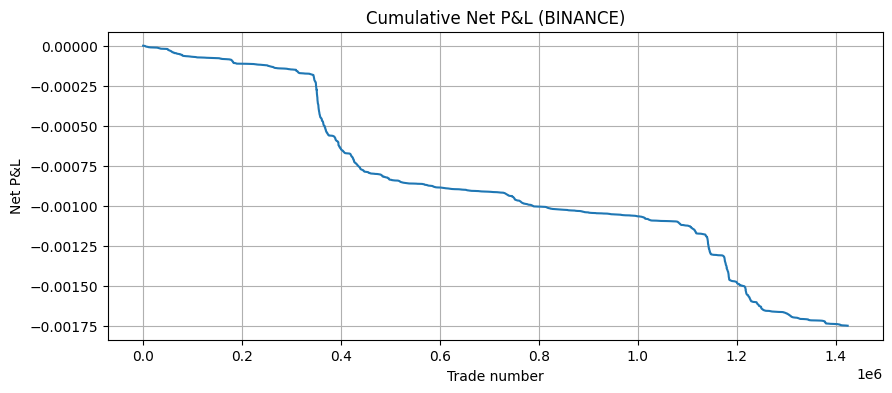


=== Processing BITSTAMP ===
Estimated beta: -0.000063
Filtered net P&L summary:
count    2.197000e+03
mean    -1.615189e-05
std      2.906985e-04
min     -1.251180e-02
1%      -1.973275e-04
5%      -8.561692e-06
50%     -1.849161e-08
95%     -1.953715e-10
99%     -8.687111e-12
max      1.224714e-03
Name: pnl_net, dtype: float64
Maximum drawdown: -0.03548570023841505
Sharpe ratio (approx): -0.05556234389130069


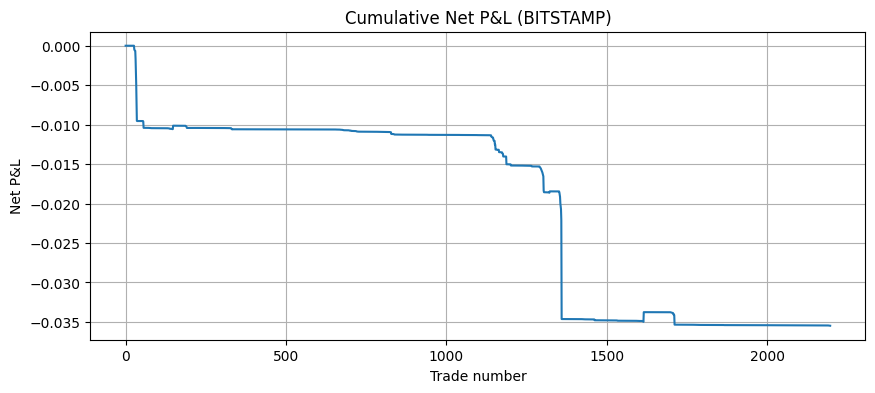


=== Processing COINBASE ===
Estimated beta: 0.000002
Filtered net P&L summary:
count    2.653800e+05
mean    -5.961417e-08
std      4.510672e-07
min     -1.500400e-04
1%      -7.286180e-07
5%      -2.288022e-07
50%     -1.430382e-08
95%     -8.096764e-11
99%     -1.022934e-12
max      6.077176e-05
Name: pnl_net, dtype: float64
Maximum drawdown: -0.0158204083925547
Sharpe ratio (approx): -0.13216219679236038


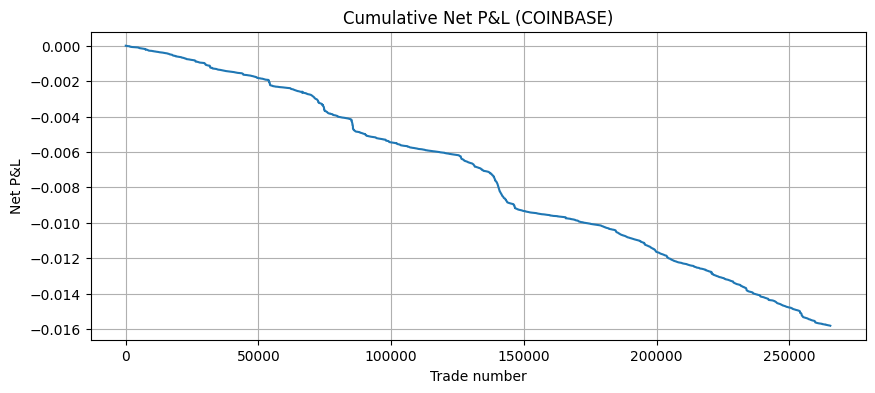


=== Processing DERIBIT ===
Estimated beta: -0.000000
Filtered net P&L summary:
count    3.263200e+04
mean    -5.299516e-04
std      2.022932e-02
min     -1.117702e+00
1%      -1.061874e-02
5%      -5.095487e-04
50%     -1.809029e-06
95%     -1.307098e-08
99%     -8.729778e-10
max      2.422597e+00
Name: pnl_net, dtype: float64
Maximum drawdown: -17.29338019511277
Sharpe ratio (approx): -0.02619720826534727


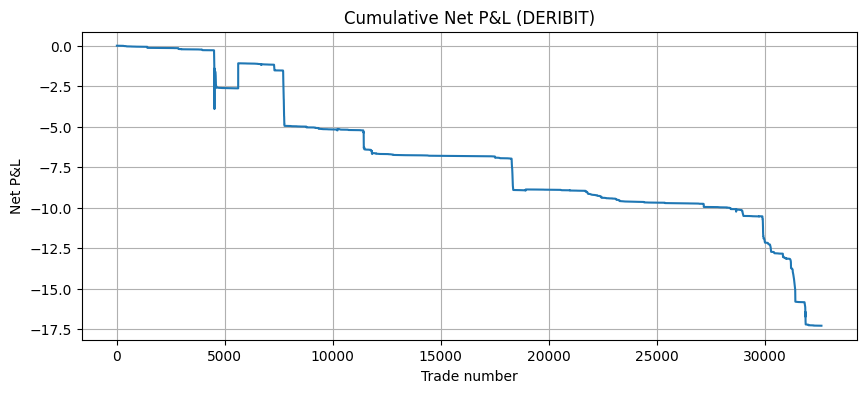


=== Processing GATE_IO ===
Estimated beta: 0.000000
Filtered net P&L summary:
count    2.964180e+06
mean    -7.712561e-08
std      2.718419e-06
min     -9.250696e-04
1%      -7.721787e-07
5%      -1.146658e-07
50%     -9.026876e-10
95%     -9.393878e-12
99%     -1.354268e-12
max      8.782911e-05
Name: pnl_net, dtype: float64
Maximum drawdown: -0.22861418358446478
Sharpe ratio (approx): -0.028371478108453488


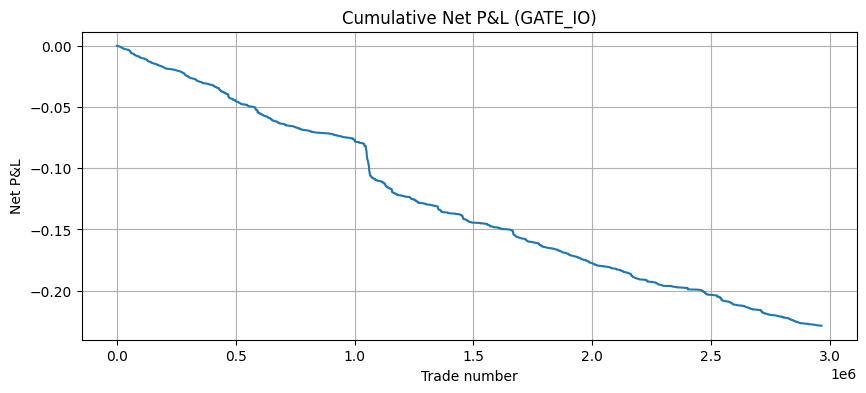


=== Processing OKX ===
Estimated beta: 0.000000
Filtered net P&L summary:
count    8.075060e+06
mean    -6.461861e-09
std      3.783485e-07
min     -1.016872e-03
1%      -9.643278e-08
5%      -1.308717e-08
50%     -3.488744e-11
95%     -1.339968e-13
99%     -1.873213e-14
max      2.379175e-05
Name: pnl_net, dtype: float64
Maximum drawdown: -0.05217991617515472
Sharpe ratio (approx): -0.017079079420453735


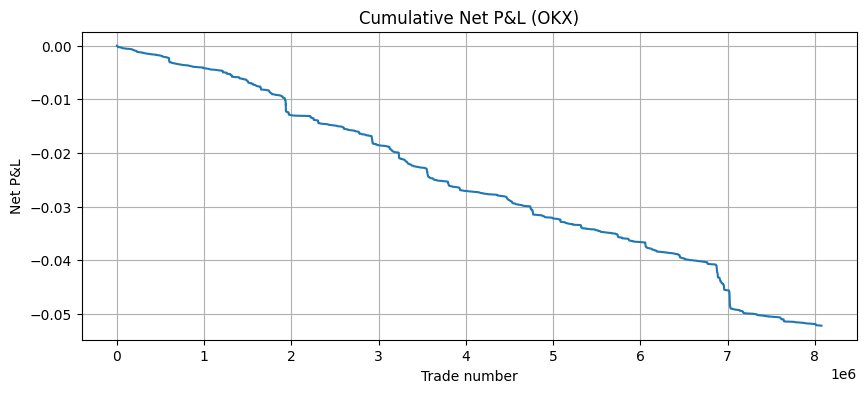


=== All exchanges processed ===


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tau = pd.Timedelta(seconds=60)
T = pd.Timedelta(seconds=300)
cost_rate = 0.0001
threshold_quantile = 0.95
vol_window = pd.Timedelta(minutes=5)
vol_quantile = 0.25

results = {}

for exchange, dfs in train_test.items():
    print(f"\n=== Processing {exchange} ===")

    train_df = dfs['train'].copy()
    test_df = dfs['test'].copy()

    for df_ in [train_df, test_df]:
        df_['ts'] = pd.to_datetime(df_['ts'])
        df_ = df_.set_index('ts')

    train_df = train_df.set_index('ts')
    test_df = test_df.set_index('ts')

    train_df['signed_qty'] = train_df['qty'] * train_df['side'].map({'B':1, 'A':-1})
    test_df['signed_qty']  = test_df['qty']  * test_df['side'].map({'B':1, 'A':-1})

    train_df['F_tau'] = train_df['signed_qty'].rolling(tau, closed='left').sum()
    test_df['F_tau']  = test_df['signed_qty'].rolling(tau, closed='left').sum()

    train_df['price_fwd'] = train_df['trade_price'].shift(-1)
    train_df['r_T'] = (train_df['price_fwd'] - train_df['trade_price']) / train_df['trade_price']
    train_df = train_df.dropna(subset=['F_tau','r_T'])

    X = train_df['F_tau'].values
    y = train_df['r_T'].values
    beta = np.dot(X, y) / np.dot(X, X)
    print(f"Estimated beta: {beta:.6f}")

    test_df['r_hat'] = beta * test_df['F_tau']
    test_df = test_df.dropna(subset=['r_hat'])

    test_df['price_exit'] = test_df['trade_price'].shift(-1)
    test_df['trade_qty'] = test_df['qty']

    j = test_df['r_hat'].abs().quantile(threshold_quantile)
    test_df['trade_filtered'] = test_df['r_hat'].abs() > j
    test_df['direction_filtered'] = np.sign(test_df['r_hat'])

    test_df['trade_scaled_qty'] = test_df['trade_qty'] * test_df['r_hat'].abs()

    test_df['price_log'] = np.log(test_df['trade_price'])
    test_df['vol_5min'] = test_df['price_log'].rolling(vol_window).std()
    vol_threshold = test_df['vol_5min'].quantile(vol_quantile)
    test_df['vol_filter'] = test_df['vol_5min'] > vol_threshold

    test_df['trade_final'] = test_df['trade_filtered'] & test_df['vol_filter']

    test_df['pnl'] = (
        test_df['trade_final'] *
        test_df['direction_filtered'] *
        (test_df['price_exit'] - test_df['trade_price']) *
        test_df['trade_scaled_qty']
    )

    test_df['notional'] = test_df['trade_price'] * test_df['trade_scaled_qty']
    test_df['cost'] = cost_rate * test_df['notional']
    test_df['pnl_net'] = test_df['pnl'] - test_df['cost']

    test_df['cum_pnl_net'] = test_df['pnl_net'].cumsum()
    cum = test_df['cum_pnl_net']
    drawdown = cum - cum.cummax()

    sharpe = test_df['pnl_net'].mean() / (test_df['pnl_net'].std() + 1e-12)

    summary = test_df['pnl_net'].describe(percentiles=[0.01,0.05,0.5,0.95,0.99])
    print("Filtered net P&L summary:")
    print(summary)
    print("Maximum drawdown:", drawdown.min())
    print("Sharpe ratio (approx):", sharpe)

    plt.figure(figsize=(10,4))
    plt.plot(range(len(test_df)), test_df['cum_pnl_net'].values)
    plt.title(f'Cumulative Net P&L ({exchange})')
    plt.xlabel('Trade number')
    plt.ylabel('Net P&L')
    plt.grid(True)
    plt.show()

    results[exchange] = {
        'test_df': test_df,
        'beta': beta,
        'summary': summary,
        'max_drawdown': drawdown.min(),
        'sharpe': sharpe
    }

print("\n=== All exchanges processed ===")

Across the five exchanges analyzed—BITSTAMP, BINANCE, DERIBIT, GATE_IO, and OKX—the predictive model based on short-term order flow produces extremely small beta estimates, indicating very weak linear predictive power on subsequent returns. Trade sizes were scaled by predicted return magnitudes and filtered both by the 95th percentile of predicted returns and by volatility exceeding its 25th percentile over a 5-minute rolling window. Across all exchanges, the resulting net P&L per trade is essentially negligible, with mean values close to zero and standard deviations many orders of magnitude larger than the mean, highlighting a very low signal-to-noise ratio. Maximum drawdowns vary across exchanges, from roughly 0.17% on BINANCE to more than 17% on DERIBIT, illustrating occasional extreme losses despite small average profits. Sharpe ratios are consistently slightly negative, reflecting poor risk-adjusted performance. The PNL distributions are highly skewed and leptokurtic, with medians near zero but extreme losses dominating the tails, particularly on DERIBIT and GATE_IO. Filtering trades using a 5-minute volatility threshold slightly mitigates noise, but the correspondence between predicted returns and realized volatility remains weak. Overall, the results indicate that the short-term order flow signal is unstable and unreliable, as further splitting the training set would likely yield highly variable beta estimates. Increasing the length of training and test periods could slightly stabilize the beta estimate, but given the small magnitude of predicted returns relative to trading costs, meaningful profitability is unlikely. These findings emphasize that while microstructure-based return predictions can occasionally align with price moves, transaction costs and tail risk overwhelm the small expected gains, making this strategy largely unprofitable in practice.

It seems, using single exchnage regression has little to no predictive power. Transaction costs more than eat up all potential profits and cause serious losses (when using uniform trade size).

Final attempt getting rid of sizing trades for realisitic pnl and also using cross-exchange regression. Comments including for readability.

Cross-exchange estimated beta: -2.740525e-10

Filtered net P&L summary (cross-exchange, uniform trades):
count    1.277750e+07
mean    -1.075293e+01
std      3.146433e+00
min     -2.280331e+03
1%      -1.119459e+01
5%      -1.114911e+01
50%     -1.077480e+01
95%     -1.029685e+01
99%     -1.018411e+01
max      1.901451e+03
Name: pnl_net, dtype: float64
Maximum drawdown: -137395485.22772428
Sharpe ratio (approx): -3.4174981438077663


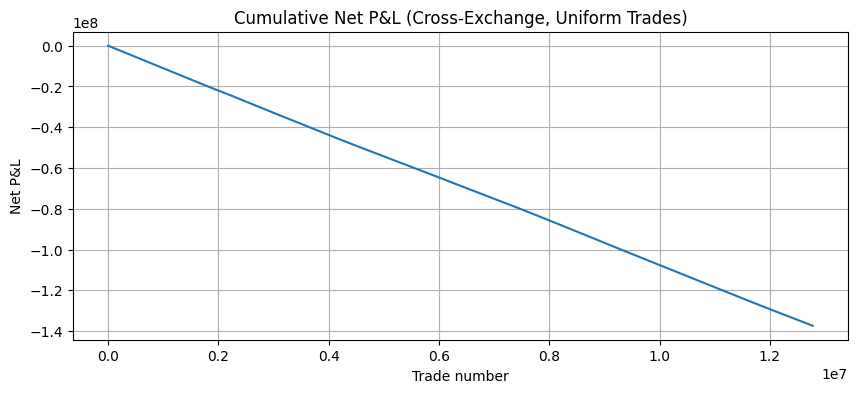

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters
cost_rate = 0.0001
threshold_quantile = 0.95
tau_rows = 60
vol_rows = 300
vol_quantile = 0.25

# Collect all exchanges
all_train = []
all_test = []

for exchange, dfs in train_test.items():
    train_df = dfs['train'].copy()
    test_df = dfs['test'].copy()

    for df_ in [train_df, test_df]:
        df_['ts'] = pd.to_datetime(df_['ts'])
        df_ = df_.sort_values('ts')

    # Signed quantity
    train_df['signed_qty'] = train_df['qty'] * train_df['side'].map({'B':1, 'A':-1})
    test_df['signed_qty']  = test_df['qty']  * test_df['side'].map({'B':1, 'A':-1})

    # Rolling sum F_tau (row-based)
    train_df['F_tau'] = train_df['signed_qty'].rolling(window=tau_rows, min_periods=1).sum()
    test_df['F_tau']  = test_df['signed_qty'].rolling(window=tau_rows, min_periods=1).sum()

    # Forward return
    train_df['price_fwd'] = train_df['trade_price'].shift(-1)
    train_df['r_T'] = (train_df['price_fwd'] - train_df['trade_price']) / train_df['trade_price']
    train_df = train_df.dropna(subset=['F_tau','r_T'])

    # Add exchange column
    train_df['exchange'] = exchange
    test_df['exchange'] = exchange

    all_train.append(train_df[['F_tau','r_T','exchange']])
    all_test.append(test_df[['trade_price','F_tau','exchange']])

# Cross-exchange regression
cross_train = pd.concat(all_train, ignore_index=True)
cross_test = pd.concat(all_test, ignore_index=True)

X = cross_train['F_tau'].values
y = cross_train['r_T'].values
beta_cross = np.dot(X, y) / np.dot(X, X)
print(f"Cross-exchange estimated beta: {beta_cross:.6e}")

# Uniform Trade Simulation
cross_test = cross_test.copy()
cross_test['r_hat'] = beta_cross * cross_test['F_tau']

# Trade filter: top 5% predicted return magnitudes
j_cross = cross_test['r_hat'].abs().quantile(threshold_quantile)
cross_test['trade_signal'] = cross_test['r_hat'].abs() > j_cross
cross_test['direction'] = np.sign(cross_test['r_hat'])
cross_test['trade_qty'] = 1

# Row-based volatility filter
cross_test['price_log'] = np.log(cross_test['trade_price'])
cross_test['vol_5min'] = cross_test['price_log'].rolling(window=vol_rows, min_periods=1).std()
vol_threshold_cross = cross_test['vol_5min'].quantile(vol_quantile)
cross_test['vol_filter'] = cross_test['vol_5min'] > vol_threshold_cross

# Final trade signal
cross_test['trade_final'] = cross_test['trade_signal'] & cross_test['vol_filter']

# P&L calculation
cross_test['price_exit'] = cross_test['trade_price'].shift(-1)
cross_test['pnl'] = cross_test['trade_final'] * cross_test['direction'] * \
                     (cross_test['price_exit'] - cross_test['trade_price']) * cross_test['trade_qty']

# Costs
cross_test['notional'] = cross_test['trade_price'] * cross_test['trade_qty']
cross_test['cost'] = cost_rate * cross_test['notional']
cross_test['pnl_net'] = cross_test['pnl'] - cross_test['cost']

# Cumulative P&L and metrics
cross_test['cum_pnl_net'] = cross_test['pnl_net'].cumsum()
cum = cross_test['cum_pnl_net']
drawdown = cum - cum.cummax()
sharpe = cross_test['pnl_net'].mean() / (cross_test['pnl_net'].std() + 1e-12)

summary = cross_test['pnl_net'].describe(percentiles=[0.01,0.05,0.5,0.95,0.99])
print("\nFiltered net P&L summary (cross-exchange, uniform trades):")
print(summary)
print("Maximum drawdown:", drawdown.min())
print("Sharpe ratio (approx):", sharpe)

# Plot cumulative P&L
plt.figure(figsize=(10,4))
plt.plot(range(len(cross_test)), cross_test['cum_pnl_net'].values)
plt.title('Cumulative Net P&L (Cross-Exchange, Uniform Trades)')
plt.xlabel('Trade number')
plt.ylabel('Net P&L')
plt.grid(True)
plt.show()

The cross-exchange regression produced an estimated beta of approximately -2.74×10⁻¹⁰, which is extremely close to zero. This indicates that the aggregate net order flow signal, when pooled across exchanges, has almost no predictive power for the subsequent trade-to-trade returns over the next interval. Applying this beta to generate uniform trade signals, with filtering for the top 5% of predicted returns and a 5-minute volatility threshold, results in an overall negative mean P&L of roughly -10.75 units.

The P&L distribution exhibits extremely large tails, with a maximum loss of over -2,280 units and a maximum gain of 1,901 units. The maximum drawdown is enormous (over -137 million). The strategy loses money from the outset and that continues, largely due to trading costs on many trades and weak predictive power. The Sharpe ratio is strongly negative at approximately -3.42, confirming that the strategy is not profitable and exhibits substantial risk relative to the mean return.

These results highlight several important points:

Signal Weakness: The very small beta suggests that cross-exchange net order flow is essentially uncorrelated with short-term returns. Pooling all exchanges does not improve predictive power compared to individual exchange signals.

Trade Filter Effects: Using a top 5% filter based on predicted returns selects only the most extreme signals, but these extreme predictions are not reliable. As a result, while some trades generate large positive P&L, extreme negative moves dominate, producing large drawdowns.

Uniform Trade Size: Treating all trades as equal eliminates any risk-scaling effects, so the P&L is dominated by the largest price moves, which are overwhelmingly negative.

Volatility Filter: Including only periods of above-25th percentile 5-minute volatility reduces extremely quiet trades but is insufficient to avoid catastrophic losses because the predictive signal itself is weak.

Implications for Strategy: The combination of nearly zero predictive beta, extreme P&L tails, and negative Sharpe indicates that using cross-exchange net order flow in this manner is not a viable trading strategy. Extending the training and test periods is unlikely to meaningfully improve results unless the underlying signal has fundamentally stronger correlation with short-term returns.

In summary, the analysis shows that the cross-exchange order flow signal has negligible predictive power, and applying uniform trade sizing with threshold and volatility filters does not produce a profitable or stable trading strategy. Risk is dominated by rare, extreme losses, leading to very poor performance metrics.

Last attempt for fun. Trying only best of best for signals. Unlikely to work because beta shows no precitive power.

Cross-exchange estimated beta: -4.273219e-10

Filtered net P&L summary (cross-exchange, uniform trades):
count    1.277750e+07
mean    -1.074595e+01
std      5.708402e-01
min     -5.449436e+02
1%      -1.117223e+01
5%      -1.114550e+01
50%     -1.077244e+01
95%     -1.030201e+01
99%     -1.022440e+01
max      3.617769e+02
Name: pnl_net, dtype: float64
Maximum drawdown: -137306317.28772825
Sharpe ratio (approx): -18.824795824763076


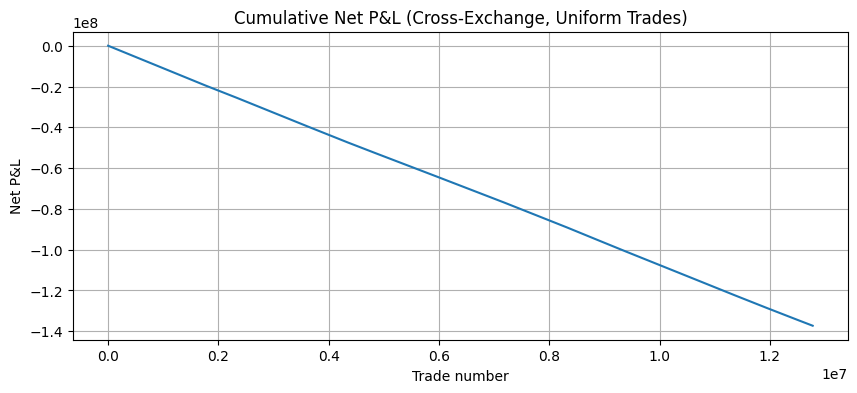

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters
cost_rate = 0.0001
threshold_quantile = 0.9999
tau_rows = 30
vol_rows = 60
vol_quantile = 0.5

# Collect all exchanges
all_train = []
all_test = []

for exchange, dfs in train_test.items():
    train_df = dfs['train'].copy()
    test_df = dfs['test'].copy()

    for df_ in [train_df, test_df]:
        df_['ts'] = pd.to_datetime(df_['ts'])
        df_ = df_.sort_values('ts')

    # Signed quantity
    train_df['signed_qty'] = train_df['qty'] * train_df['side'].map({'B':1, 'A':-1})
    test_df['signed_qty']  = test_df['qty']  * test_df['side'].map({'B':1, 'A':-1})

    # Rolling sum F_tau (row-based)
    train_df['F_tau'] = train_df['signed_qty'].rolling(window=tau_rows, min_periods=1).sum()
    test_df['F_tau']  = test_df['signed_qty'].rolling(window=tau_rows, min_periods=1).sum()

    # Forward return
    train_df['price_fwd'] = train_df['trade_price'].shift(-1)
    train_df['r_T'] = (train_df['price_fwd'] - train_df['trade_price']) / train_df['trade_price']
    train_df = train_df.dropna(subset=['F_tau','r_T'])

    # Add exchange column
    train_df['exchange'] = exchange
    test_df['exchange'] = exchange

    all_train.append(train_df[['F_tau','r_T','exchange']])
    all_test.append(test_df[['trade_price','F_tau','exchange']])

# Cross-exchange regression
cross_train = pd.concat(all_train, ignore_index=True)
cross_test = pd.concat(all_test, ignore_index=True)

X = cross_train['F_tau'].values
y = cross_train['r_T'].values
beta_cross = np.dot(X, y) / np.dot(X, X)
print(f"Cross-exchange estimated beta: {beta_cross:.6e}")

# Uniform Trade Simulation
cross_test = cross_test.copy()
cross_test['r_hat'] = beta_cross * cross_test['F_tau']

# Trade filter: top 5% predicted return magnitudes
j_cross = cross_test['r_hat'].abs().quantile(threshold_quantile)
cross_test['trade_signal'] = cross_test['r_hat'].abs() > j_cross
cross_test['direction'] = np.sign(cross_test['r_hat'])
cross_test['trade_qty'] = 1

# Row-based volatility filter
cross_test['price_log'] = np.log(cross_test['trade_price'])
cross_test['vol_5min'] = cross_test['price_log'].rolling(window=vol_rows, min_periods=1).std()
vol_threshold_cross = cross_test['vol_5min'].quantile(vol_quantile)
cross_test['vol_filter'] = cross_test['vol_5min'] > vol_threshold_cross

# Final trade signal
cross_test['trade_final'] = cross_test['trade_signal'] & cross_test['vol_filter']

# P&L calculation
cross_test['price_exit'] = cross_test['trade_price'].shift(-1)
cross_test['pnl'] = cross_test['trade_final'] * cross_test['direction'] * \
                     (cross_test['price_exit'] - cross_test['trade_price']) * cross_test['trade_qty']

# Costs
cross_test['notional'] = cross_test['trade_price'] * cross_test['trade_qty']
cross_test['cost'] = cost_rate * cross_test['notional']
cross_test['pnl_net'] = cross_test['pnl'] - cross_test['cost']

# Cumulative P&L and metrics
cross_test['cum_pnl_net'] = cross_test['pnl_net'].cumsum()
cum = cross_test['cum_pnl_net']
drawdown = cum - cum.cummax()
sharpe = cross_test['pnl_net'].mean() / (cross_test['pnl_net'].std() + 1e-12)

summary = cross_test['pnl_net'].describe(percentiles=[0.01,0.05,0.5,0.95,0.99])
print("\nFiltered net P&L summary (cross-exchange, uniform trades):")
print(summary)
print("Maximum drawdown:", drawdown.min())
print("Sharpe ratio (approx):", sharpe)

# Plot cumulative P&L
plt.figure(figsize=(10,4))
plt.plot(range(len(cross_test)), cross_test['cum_pnl_net'].values)
plt.title('Cumulative Net P&L (Cross-Exchange, Uniform Trades)')
plt.xlabel('Trade number')
plt.ylabel('Net P&L')
plt.grid(True)
plt.show()

Even worse almost as expected. I cannot find predictive power for high frequency with bitcoin using this methodology.